# Multi-step naive forecasting

In the previous section, we forecasted one step ahead; that is, we forecasted the pollutant concentration for the next hour. 

Very often, we want to forecast more than one step ahead. For example, we want to forecast the pollutant concentration **every hour over the next 24 hours**.

In this notebook, we will examine one procedure for **multi-step forecasting**. 

First, we will predict the pollutant hourly concentration in the next 24 hours with a naive forecast. The naive forecast predicts the next value based on the previous pollutant concentration value. This way, we will become familiar with the procedure and the challenges of multi-step forecasting. 

In the following notebooks, we will carry out multi-step forecasting utilizing linear regression.

**For simplicity, we will only forecast the concentration of carbon monoxide (CO).**


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load data

In [2]:
# If you followed the instructions to download the data,
# it should be located here:

filename = "../datasets/AirQualityUCI_ready.csv"

# Load data: only the time variable and CO concentration.

# Passing the `Date_Time` column to the parse_dates argument
# will mean that pandas converts the type of the column to a
# datetime on loading the data.

data = pd.read_csv(
    filename,
    usecols=["Date_Time", "CO_sensor"],
    parse_dates=["Date_Time"],
    index_col=["Date_Time"],
)

print(data.shape)

data.head()

(9357, 1)


,CO_sensor
Date_Time,
2004-10-03 18:00:00,1360.0
2004-10-03 19:00:00,1292.0
2004-10-03 20:00:00,1402.0
2004-10-03 21:00:00,1376.0
2004-10-03 22:00:00,1272.0


In [3]:
# Sanity: sort index.

data.sort_index(inplace=True)

## Reduce data span

We narrow down the dataset to those portions with fewer timestamps missing.

We discussed this in section 2.

In [4]:
# Reduce the time span.
data = data["2004-04-01":"2005-04-30"]

# Quick check: data span.
data.index.min(), data.index.max()

(Timestamp('2004-04-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

## Remove outliers

Outliers are the negative values returned by the sensors.

We discussed this in section 2.

In [5]:
print(data.shape)

# Remove negative observations.
data = data.loc[(data["CO_sensor"] > 0)]

print(data.shape)

(7677, 1)
(7393, 1)


In [6]:
# The data, ready to use.

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Split data into train and test

We "train" the model on a training set and evaluate its performance on a test set. It is good practice to evaluate models on datasets that were not used for training.

Our model does not learn any parameters from the data in this case. That is why I wrote "train" in inverted commas.

But to compare our benchmark model with our linear regression (which we will train in the next notebook), we need to train and evaluate them in the same conditions.

In [7]:
# Split the data: we leave the last month
# for evaluation.

X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

X_train.shape, X_test.shape

((6850, 1), (543, 1))

# Naive forecast

We will predict the pollutant's concentration at time *t* with its value at time *t-1*. 

This is our benchmark model.

In [8]:
# Create a class that returns the naive
# forecast:

# It returns the pollutant concentration
# in the previous hour as the prediction.

# We create a class so that it works
# like a Scikit-learn algorithm.


class NaiveForecast:
    def predict(self, X):

        # Return the pollutant concentration
        # in the previous hour.

        pred = X["CO_sensor"].shift(freq="1H")

        return pred

In [9]:
# Set up the naive forecast.

naive = NaiveForecast()

In [10]:
# Make predictions.

# We can use it like any Scikit-learn
# estimator.

preds = naive.predict(X_train)

preds

Date_Time
2004-04-04 01:00:00    1224.0
2004-04-04 02:00:00    1215.0
2004-04-04 03:00:00    1115.0
2004-04-04 04:00:00    1124.0
2004-04-04 05:00:00    1028.0
                        ...  
2005-03-03 20:00:00    1473.0
2005-03-03 21:00:00    1396.0
2005-03-03 22:00:00    1285.0
2005-03-03 23:00:00    1206.0
2005-03-04 00:00:00    1179.0
Name: CO_sensor, Length: 6850, dtype: float64

In [11]:
# Let's concatenate our predictions with
# our training data.

pd.concat([X_train, preds], axis=1)

,CO_sensor,CO_sensor
Date_Time,,
2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,1215.0,1224.0
2004-04-04 02:00:00,1115.0,1215.0
2004-04-04 03:00:00,1124.0,1115.0
2004-04-04 04:00:00,1028.0,1124.0
...,...,...
2005-03-03 20:00:00,1396.0,1473.0
2005-03-03 21:00:00,1285.0,1396.0
2005-03-03 22:00:00,1206.0,1285.0


As we see, we do not have a prediction for the first value in the dataset because we do not know the pollutant's former concentration. And we can already predict the concentration for March 4th at 00 hr, a date that we do not have in our train set.

# Multi-step forecasting

To carry out multi-step forecasting, first we make the prediction for the next hour, and then we use that prediction value as a new feature to predict the concentration for the following hour, and so on.

## Forecasting 1 hour forward

In our training set, we've got data up to March 3rd at 23 hr. Let's use that data to forecast the pollutant concentration for March 4th at 00 hr.

In [12]:
# The last value in the train set.

X_train.tail(1)

,CO_sensor
Date_Time,
2005-03-03 23:00:00,1179.0


In [13]:
# Forecast the pollutant concentration in the next
# hour.

pred = naive.predict(X_train.tail(1))

pred

Date_Time
2005-03-04    1179.0
Name: CO_sensor, dtype: float64

In [14]:
# Capture our prediction in a dataframe

step = pd.DataFrame(pred)

step

,CO_sensor
Date_Time,
2005-03-04,1179.0


To make a multi-step forecast, we use the prediction as a new value, and make a further prediction using this value.

In [15]:
# Use our prediction as input to predict
# pollutant concentration in the following hour.

pred = naive.predict(step)

pred

Date_Time
2005-03-04 01:00:00    1179.0
Name: CO_sensor, dtype: float64

In [16]:
# And now we repeat to predict in the following hour:

pred = naive.predict(pd.DataFrame(pred))

pred

Date_Time
2005-03-04 02:00:00    1179.0
Name: CO_sensor, dtype: float64

And so on. You get the gist.

Because this is a naive forecast and we always predict the last value, it is clear that the multi-step forecast will always show the same value. It will be a constant prediction.

## Forecasting 24 hours forward

Let's now go ahead and predict the next 24 hours of pollutant concentration.

In [17]:
# Predict pollutant in the next hour.
pred = naive.predict(X_train.tail(1))

# Capture prediction in df.
pred = pd.DataFrame(pred)

pred

,CO_sensor
Date_Time,
2005-03-04,1179.0


In [18]:
# We'll capture the 24 hr forecasts in a new
# dataframe.
preds = pred.copy()


# Now we use the prediction as input to make
# the prediction in the following hour.

# And we repeat the process 23 times:
for i in range(23):

    # predict pollutant concentration in
    # the next hour.
    pred = pd.DataFrame(naive.predict(pred))

    # Append to our predictions dataframe.
    preds = preds.append(
        pred,
        ignore_index=False,
        verify_integrity=True,
        sort=True,
    )

# Our 24 hr forecast.
preds

,CO_sensor
Date_Time,
2005-03-04 00:00:00,1179.0
2005-03-04 01:00:00,1179.0
2005-03-04 02:00:00,1179.0
2005-03-04 03:00:00,1179.0
2005-03-04 04:00:00,1179.0
2005-03-04 05:00:00,1179.0
2005-03-04 06:00:00,1179.0
2005-03-04 07:00:00,1179.0
2005-03-04 08:00:00,1179.0


The naive forecast always returns the same value, because, well, it is a naive forecast.

Text(0, 0.5, 'CO concentration')

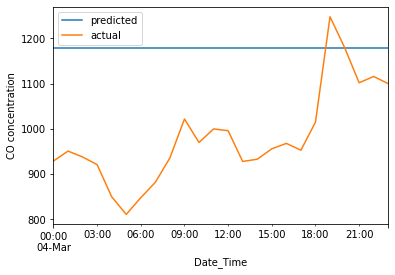

In [19]:
# We can plot our predictions vs. the truth.
# The real values of CO are in the first
# rows of the test set.

# Join predictions and real values.
# We need to add suffixes because both
# dataframes' columns have the same name.
tmp = preds.join(X_test, on="Date_Time", lsuffix="_left", rsuffix="_right")

# Rename columns.
tmp.columns = ["predicted", "actual"]

# plot
tmp.plot()
plt.ylabel("CO concentration")

We see that the predictions were not great. This was to be expected, because, well, we are making a naive forecast.

In [20]:
# And now we calculate the RMSE for the 24 hr.
# predictions.

print(
    "rmse: ",
    mean_squared_error(
        y_true=tmp["actual"],
        y_pred=tmp["predicted"],
        squared=False,
    ),
)

rmse:  222.68372564394252


# Back-testing with expanding window

Now, we will make predictions with an expanding window. We will "train" the model up to a certain point, and then make predictions 24 hours ahead. We will then "train" the model up to a point further in the future, and make predictions 24 hours ahead. And so on.



<img src='../images/backtesting.png' width="600" height="600">


In [21]:
# Capture first day on test set.

start = X_test.index.min()
start

Timestamp('2005-03-04 00:00:00')

In [22]:
# Capture last day on test set.

end = X_test.index.max()
end

Timestamp('2005-04-04 14:00:00')

In [23]:
# Create a 24 hr date range.

pd.date_range(start=start, end=end, freq="24H")

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', freq='24H')

Our expanding windows correspond to adding 1 additional day of data to the "train" set.

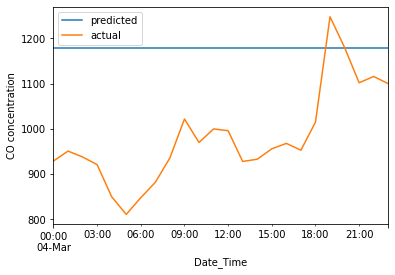

rmse:  222.68372564394252


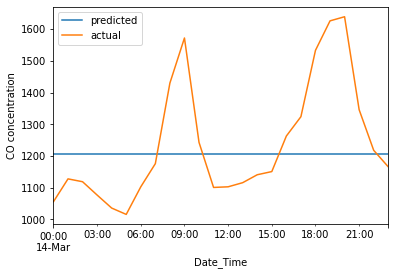

rmse:  189.26051269788599


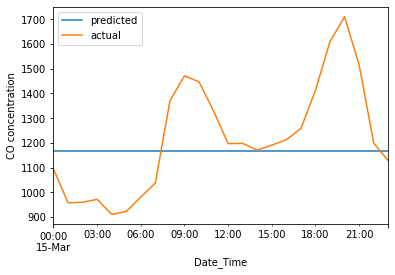

rmse:  226.84006847703662


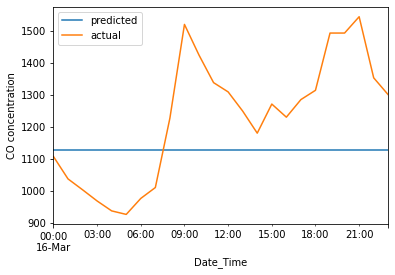

rmse:  216.43205246296893


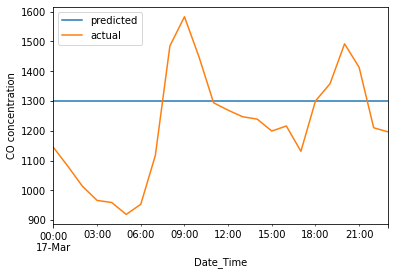

rmse:  198.68725424646644


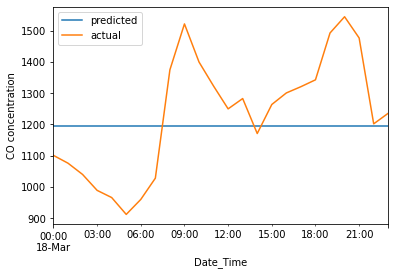

rmse:  189.15910410727437


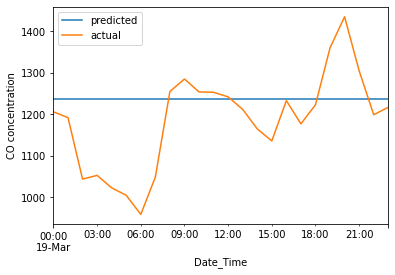

rmse:  123.78947181942951


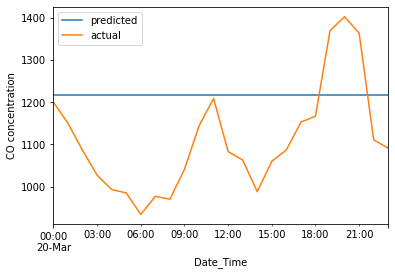

rmse:  164.07442416984637


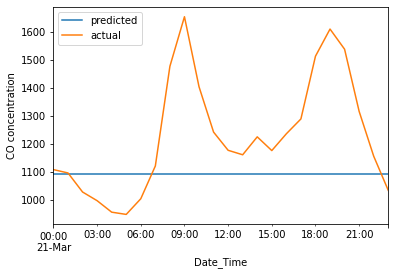

rmse:  245.247833833451


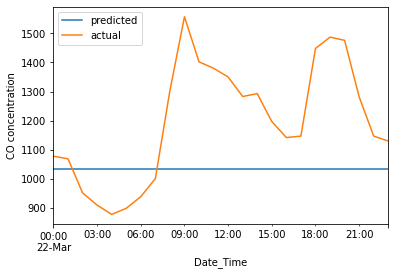

rmse:  259.9884612824192


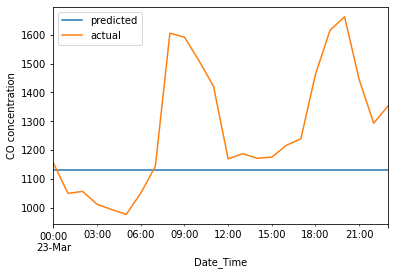

rmse:  256.5659434401482


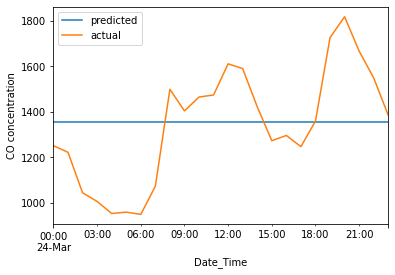

rmse:  249.47428057149833


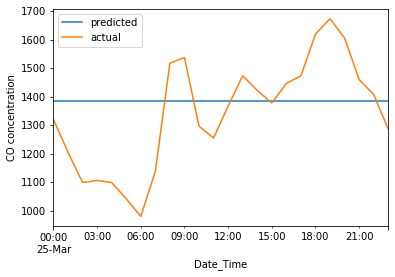

rmse:  194.6204639805383


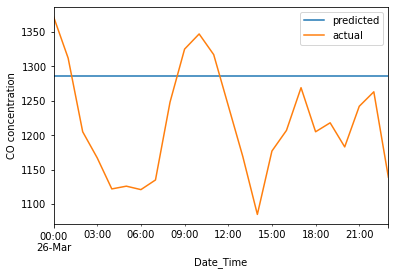

rmse:  103.91923947630359


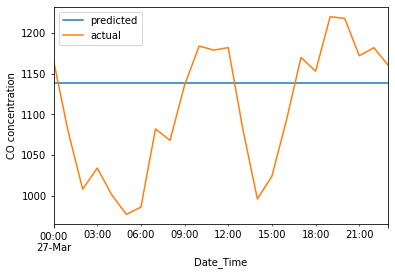

rmse:  84.49901380095115


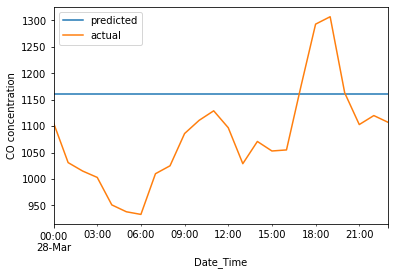

rmse:  122.13960591607186


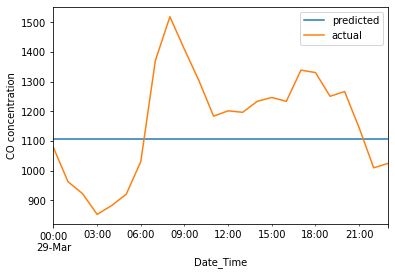

rmse:  185.11055255351238


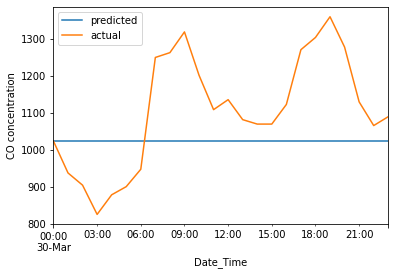

rmse:  170.41958025219208


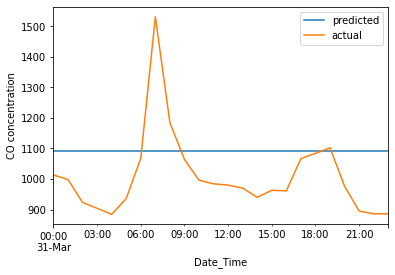

rmse:  156.03298262440114


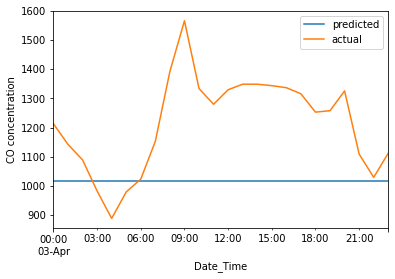

rmse:  254.51252424979012


In [24]:
# We collect the RMSE for each
# test set portion examined.
rmse_ls = []


# Now we loop, expanding the train set 24 hr.
# on each round.

for date in pd.date_range(start=start, end=end, freq="24H"):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < date]
    X_test = data[data.index >= date]

    # Multi-step forecast:
    # =====================

    # Predict pollutant in the next hour
    pred = naive.predict(X_train.tail(1))

    # Capture prediction in df.
    pred = pd.DataFrame(pred)

    # We'll capture the 24 hr forecast in a new
    # dataframe.
    preds = pred.copy()

    for i in range(23):

        # Predict pollutant concentration in
        # the next hour.
        pred = pd.DataFrame(naive.predict(pred))

        # Append to our predictions dataframe.
        preds = preds.append(
            pred,
            ignore_index=False,
            verify_integrity=True,
            sort=True,
        )

    # ==================================================
    # Remember that we do not have timestamps for every
    # hour in our test set (discussed in Section 2).

    # We will plot only those cases where we do have
    # the real values of the target.
    # ==================================================

    # Join predictions and real values.
    tmp = preds.join(X_test, on="Date_Time", lsuffix="_left", rsuffix="_right")

    # Rename columns in dataframe.
    tmp.columns = ["predicted", "actual"]

    # Check that we have all real values of
    # the actual time series.
    if not tmp["actual"].isnull().any():

        tmp.plot()
        plt.ylabel("CO concentration")
        plt.show()

        # Determine the RMSE.
        rmse_ = mean_squared_error(
            y_true=tmp["actual"],
            y_pred=tmp["predicted"],
            squared=False,
        )
        print("rmse: ", rmse_)

        # Append the RMSE to our list.
        rmse_ls.append(rmse_)

We made 24 hr forecasts for multiple chunks of the test set.

To wrap-up, we determine the mean RMSE for every day in the test set that we examined.

In [25]:
# Mean performance during cross-validation.

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  190.6728547803064 +- 51.50548061382903
Number of days evaluated:  20


That is all for this notebook. 

In the next one, we will expand this procedure to a linear regression.